In [1]:
import numpy as np
import pickle
import tensorly as tf
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.padder import PaddingTransformer
import pandas as pd
import warnings
import time
from MUDRA import MUDRA
from sklearn.preprocessing import normalize

## for the purpose of readability
import warnings
warnings.filterwarnings("ignore")

rng = np.random.default_rng()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cmap = plt.cm.Spectral(np.linspace(0, 1, 25))

In [2]:
def imputation_padding(X):
    paddedX = []
    for i in range(len(X)):
        currX = X[i]
        newX = currX[0,:]
        prevTPoint = -1
        for idx, tPoint in enumerate(currX[1:,0]):
            if tPoint - prevTPoint > 1:
                for j in range((tPoint - prevTPoint - 1).astype('int')):
                    newX = np.vstack((newX, np.zeros(currX.shape[1])))
            newX = np.vstack((newX, currX[idx+1,:]))
            prevTPoint = tPoint
        if prevTPoint < 11.:
            for j in range((11 - prevTPoint).astype('int')):
                newX = np.vstack((newX, np.zeros(currX.shape[1])))
        newX[1:,0] = np.arange(12)
        currX = newX
        newX = np.atleast_2d(currX[:,0]).T
        prevFeat = -1
        for idx, feat in enumerate(currX[0,1:]):
            if feat - prevFeat > 1:
                for j in range((feat - prevFeat - 1).astype('int')):
                    newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
            newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
            prevFeat = feat
        if prevFeat < 8:
            for j in range((8 - prevFeat).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX[0,1:] = np.arange(9)
        paddedX.append(newX)
    return paddedX

def end_padding(X):
    paddedX = []
    for i in range(len(X)):
        currX  = X[i]
        newX = np.atleast_2d(currX[:,0]).T
        prevFeat = -1
        for idx, feat in enumerate(currX[0,1:]):
            if feat - prevFeat > 1:
                for j in range((feat - prevFeat - 1).astype('int')):
                    newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
            newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
            prevFeat = feat
        if prevFeat < 8:
            for j in range((8 - prevFeat).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX[0,1:] = np.arange(9)
        paddedX.append(newX)
    return paddedX
    
def convertToDataFrame(X):
    X_df = []
    tmp = np.zeros(9)
    tmp[:] = np.nan
    for i in range(len(X)):
        X_df.append(tmp.tolist())
        for j in range(1, X[i].shape[1]):
            X_df[-1][X[i][0,j].astype('int')] = pd.Series(X[i][1:,j], index=X[i][1:,0])
    return pd.DataFrame(X_df)

# Data Loading and Preprocessing

The data is in the form of two lists: $X$ and $y$, each of size `n_samples`. $y$ is simply a list of targets, where each element is the class that the corresponding element in $X$ belongs to. $X$ is a list of $(T_i+1)\times(F_i+1)$ matrices, where the first column stores the timepoints and the first row stores the features recorded for each sample. The other elements are feature values at the corresponding timepoints.

## Data Loading and Plotting

The data is loaded from the `data.pickle` file, and one sample from each class is plotted. Each plot represents one feature, and each colour represents one class.

# Model

The model is implemented as an instance of a scikit-learn `estimator` class. It implements interface functions `transform`, `fit_transform`, `predict`, `predict_proba` and `predict_log_proba` according to the specification, and can also be used in the beginning of a scikit-learn `Pipeline` in order to transform irregular tensor data into an `n_samples`$\times$`r` matrix, which can then be further processed using other scikit-learn estimators.

Assume that data is recorded at $T$ timepoints and for $F$ features. Let there be $K$ classes $i=1,2,\ldots,K$ and $j=1,2,\ldots,m_i$ subjects in each class. For each subject, let the timepoints recorded be $t_1, t_2,\ldots,t_{T_{ij}}$ and the features recorded be $f_1,f_2,\ldots,f_{F_{ij}}$. The model can be described as $$Y_{ij}=S_{ij}(\lambda_0 + \Lambda\alpha_i\xi + \gamma_{ij})C_{ij} + \epsilon_{ij}$$
Here $Y_{ij}\in\mathbb{R}^{T_{ij}\times F_{ij}}$ are the data matrices, where each row is a timepoint and each column is a feature. $S_{ij}$s are the spline matrices, formed from the spline basis function set $\{\mathbf{s}_1(t), \mathbf{s}_2(t),\ldots,\mathbf{s}_b(t)\}$. Similar to $Y_{ij}$, the rows are timepoints and the columns are basis functions, so the matrix is defined as $$S_{ij}=\begin{bmatrix}
\mathbf{s}_1(t_1) &\mathbf{s}_2(t_1) &\cdots &\mathbf{s}_b(t_1)\\
\mathbf{s}_1(t_2) &\mathbf{s}_2(t_2) &\cdots &\mathbf{s}_b(t_2)\\
&\vdots\\
\mathbf{s}_1(t_{T_{ij}}) &\mathbf{s}_2(t_{T_{ij}}) &\cdots &\mathbf{s}_b(t_{T_{ij}})\\
\end{bmatrix}$$ $C_{ij}\in\mathbb{R}^{F\times F_{ij}}$ are the $\{f_1^{th}, f_2^{th},\ldots,f_{F_{ij}}^{th}\}$ columns of an $F\times F$ identity matrix, $\lambda_0\in\mathbb{R}^{b\times F}$ is the mean parameter, $\alpha_i\in\mathbb{R}^{r\times r}$s are the reduced rank linear discriminants, $\Lambda\in\mathbb{R}^{b\times r}$ and $\xi\in\mathbb{R}^{r\times F}$ are matrices used to compute the full rank linear discriminants, $\gamma_{ij}\in\mathcal{N}_{b\times F}(0,\Sigma,\Psi)$ is the internal autoregressive noise and $\epsilon_{ij}\sim\mathcal{N}_{T_{ij}\times F_{ij}}(0,\sigma^2I)$ is the measurement noise.
We use an ECM algorithm to fit the model to the data, for computational efficiency.

## Missing Data

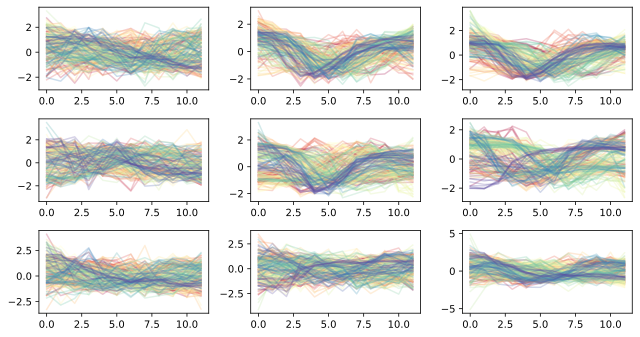

In [3]:
X, y = pickle.load(open("datasets/trainWordRecognitionMissing.pickle", 'rb'))
X_test, y_test = pickle.load(open("datasets/testWordRecognitionReducedMissing.pickle", 'rb'))
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(len(X)):
    featIdx = X[i][0,1:].astype('int')
    for col, j in enumerate(featIdx):
        ax[j//3, j%3].plot(X[i][1:,0], X[i][1:,col+1], color=cmap[y[i] - 1], alpha=0.25)
fig.tight_layout()
imputationPaddedX = convertToDataFrame(imputation_padding(X))
imputationPaddedX_test = convertToDataFrame(imputation_padding(X_test))
endPaddedX = convertToDataFrame(end_padding(X))
endPaddedX_test = convertToDataFrame(end_padding(X_test))
X = convertToDataFrame(X)
X_test = convertToDataFrame(X_test)

In [6]:
X

0  \
0    0.0     0.87159
2.0     0.97260
4.0     0.8098...   
1    0.0     2.742800
1.0     1.606700
2.0     1.09...   
2    0.0     0.97990
2.0     1.08200
3.0     0.9569...   
3                                                  NaN   
4    0.0    -1.88610
1.0    -0.96585
2.0     0.2495...   
..                                                 ...   
270  0.0     0.66787
1.0     0.70793
2.0     1.2165...   
271                                                NaN   
272  0.0     1.27290
1.0     1.24780
2.0     1.2720...   
273  0.0     1.926600
1.0     1.537600
2.0     1.69...   
274                                                NaN   

                                                     1  \
0    0.0     0.74530
2.0     0.69116
4.0     0.1569...   
1    0.0     1.48750
1.0     0.76216
2.0    -0.1851...   
2                                                  NaN   
3                                                  NaN   
4    0.0    -1.22930
1.0    -0.18634
2.0     0.5788...   
..                                                 ...   
270  0.0     0.74874
1.0     0.62551
2.0     0.0682...   
271                                                NaN   
272  0.0     1.35490
1.0     1.17770
2.0     0.4544...   
273  0.0     0.84725
1.0     0.47900
2.0    -0.9284...   
274  0.0     1.41440
1.0     1.36720
3.0    -1.1871...   

                                                     2  \
0    0.0     1.15330
2.0     0.98584
4.0     0.6940...   
1                                                  NaN   
2    0.0     0.96637
2.0     1.10620
3.0     1.1397...   
3                                                  NaN   
4    0.0    -1.093100
1.0    -0.179880
2.0     0.79...   
..                                                 ...   
270  0.0     1.41020
1.0     1.18880
2.0     0.3653...   
271                                                NaN   
272  0.0     1.541600
1.0     1.474100
2.0     0.44...   
273  0.0     1.01010
1.0     0.72576
2.0    -0.7446...   
274  0.0     1.57900
1.0     1.53280
3.0    -0.8581...   

                                                     3  \
0    0.0     0.38622
2.0     0.54420
4.0     1.3349...   
1    0.0     1.38920
1.0     1.31690
2.0     1.2721...   
2                                                  NaN   
3    0.0     0.64772
1.0     0.83136
3.0     0.6743...   
4    0.0    -0.10898
1.0     0.26242
2.0     0.6578...   
..                                                 ...   
270  0.0     1.84370
1.0     1.86080
2.0     1.7018...   
271  0.0     2.072300
1.0     1.525800
2.0     1.70...   
272  0.0     1.27000
1.0     1.43850
2.0     2.0823...   
273  0.0    -0.224020
1.0    -0.016942
2.0    -0.83...   
274  0.0     1.380100
1.0     1.135800
3.0     0.00...   

                                                     4  \
0    0.0     1.51560
2.0     1.34350
4.0     0.7299...   
1                                                  NaN   
2    0.0     0.73842
2.0     1.27560
3.0     1.3080...   
3    0.0     2.19900
1.0     1.55440
3.0     0.1499...   
4    0.0    -0.91073
1.0    -0.42549
2.0     0.6572...   
..                                                 ...   
270  0.0     0.72652
1.0     1.05870
2.0     0.2245...   
271  0.0     1.398800
1.0     1.476300
2.0     1.33...   
272  0.0     1.514200
1.0     1.517300
2.0     0.65...   
273  0.0     1.326100
1.0     1.069600
2.0    -0.55...   
274  0.0     1.48630
1.0     1.60860
3.0    -0.5298...   

                                                     5  \
0    0.0    -0.71550
2.0    -0.91657
4.0    -0.8444...   
1    0.0    -1.85940
1.0    -1.32390
2.0    -0.7482...   
2                                                  NaN   
3    0.0    -1.179800
1.0    -1.098400
3.0    -0.78...   
4    0.0     0.33376
1.0    -0.14059
2.0    -0.4814...   
..                                                 ...   
270                                                NaN   
271                                                NaN   
272  0.0    -1.57270
1.0    -1.74630
2.0    -1

In [4]:
model = MUDRA(r=8, n_iter=300, nBasis=9).fit(X, y)

In [5]:
x = model.transform(X)
classifier = RidgeClassifierCV().fit(x, y)
x = model.transform(X_test)
print(classification_report(y_test, classifier.predict(x)))

              precision    recall  f1-score   support

           1       0.91      0.83      0.87        12
           2       0.77      0.83      0.80        12
           3       0.79      0.92      0.85        12
           4       0.80      0.67      0.73        12
           5       0.63      1.00      0.77        12
           6       0.92      1.00      0.96        12
           7       0.69      0.92      0.79        12
           8       0.82      0.75      0.78        12
           9       1.00      0.58      0.74        12
          10       0.83      0.83      0.83        12
          11       0.61      0.92      0.73        12
          12       0.82      0.75      0.78        12
          13       0.67      0.83      0.74        12
          14       0.70      0.58      0.64        12
          15       1.00      0.75      0.86        12
          16       0.73      0.67      0.70        12
          17       1.00      0.50      0.67        12
          18       0.83    

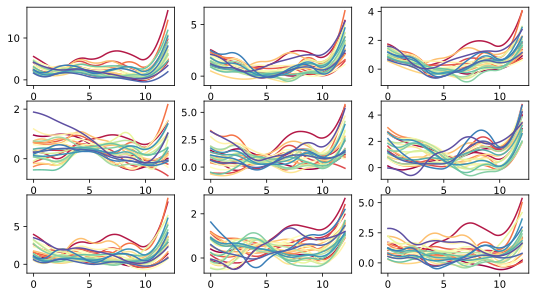

In [6]:
xs = np.linspace(0, 12, 100)
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
    ys = model.getClassFunctionals(xs, i+1)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Padding Type-1: "imputation"

In [7]:
rocketPipeline = make_pipeline(Rocket(num_kernels=41), RidgeClassifierCV())
rocketPipeline.fit(imputationPaddedX, y)
print(classification_report(y_test, rocketPipeline.predict(imputationPaddedX_test)))

              precision    recall  f1-score   support

           1       0.60      0.75      0.67        12
           2       0.48      0.83      0.61        12
           3       0.67      0.67      0.67        12
           4       0.56      0.42      0.48        12
           5       0.67      0.83      0.74        12
           6       0.67      0.83      0.74        12
           7       0.42      0.67      0.52        12
           8       0.54      0.58      0.56        12
           9       0.86      0.50      0.63        12
          10       0.45      0.42      0.43        12
          11       0.64      0.58      0.61        12
          12       0.55      0.50      0.52        12
          13       0.54      0.58      0.56        12
          14       0.71      0.42      0.53        12
          15       0.69      0.75      0.72        12
          16       0.60      0.25      0.35        12
          17       0.67      0.33      0.44        12
          18       0.45    

### Padding Type-2: "end"

In [8]:
rocketPipeline = make_pipeline(PaddingTransformer(), Rocket(num_kernels=41), RidgeClassifierCV())
rocketPipeline = rocketPipeline.fit(endPaddedX, y)
print(classification_report(y_test, rocketPipeline.predict(endPaddedX_test)))

              precision    recall  f1-score   support

           1       0.44      0.58      0.50        12
           2       0.47      0.58      0.52        12
           3       0.55      0.50      0.52        12
           4       0.40      0.33      0.36        12
           5       0.44      0.33      0.38        12
           6       0.64      0.75      0.69        12
           7       0.60      0.75      0.67        12
           8       0.39      0.58      0.47        12
           9       0.62      0.67      0.64        12
          10       0.53      0.67      0.59        12
          11       0.78      0.58      0.67        12
          12       0.17      0.08      0.11        12
          13       0.55      0.50      0.52        12
          14       0.27      0.25      0.26        12
          15       0.50      0.33      0.40        12
          16       0.50      0.33      0.40        12
          17       0.50      0.33      0.40        12
          18       0.43    

## No missing data

In [39]:
X, y = pickle.load(open("datasets/trainWordRecognition.pickle", 'rb'))
X_test, y_test = pickle.load(open("datasets/testWordRecognitionReduced.pickle", 'rb'))
X = convertToDataFrame(X)
X_test = convertToDataFrame(X_test)

In [10]:
accTable = np.zeros((8, 2))
for r in tqdm(range(2, 10)):
    rocketAccuracy = 0
    modelPipeline = make_pipeline(MUDRA(r=r, n_iter=500, nBasis=9), RidgeClassifierCV())
    rocketPipeline = make_pipeline(Rocket(num_kernels=(r**2 + 1)//2), RidgeClassifierCV())
    for _ in range(100):
        rocketPipeline.fit(X, y)
        rocketAccuracy += classification_report(y_test, rocketPipeline.predict(X_test), output_dict=True)['weighted avg']['f1-score']
        modelPipeline.fit(X, y)
        modelAccuracy = classification_report(y_test, modelPipeline.predict(X_test), output_dict=True)['weighted avg']['f1-score']
    rocketAccuracy /= 100
    modelAccuracy /= 100
    accTable[r - 2,:] = [modelAccuracy, rocketAccuracy]
pd.DataFrame(accTable, index=range(2, 10), columns=['Model Accuracy', 'Rocket Accuracy']).to_csv('rocket_vs_mudra.csv')

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
times = np.zeros((100, 2))
modelPipeline = make_pipeline(MUDRA(r=7, n_iter=500, nBasis=9), RidgeClassifierCV())
rocketPipeline = make_pipeline(Rocket(num_kernels=(7**2 + 1)//2), RidgeClassifierCV())
for k in tqdm(range(100)):
    
    start = time.time()
    rocketPipeline.fit(X, y)
    end = time.time()
    times[k, 0] = end - start
    start = time.time()
    modelPipeline.fit(X, y)
    end = time.time()
    times[k, 1] = end - start

pd.DataFrame(times, columns=['ROCKET', 'MUDRA']).to_csv('times.csv')

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
pd.read_csv('rocket_vs_mudra2.csv', index_col=0)

Model Accuracy  Rocket Accuracy
2        0.027775         0.130694
3        0.079790         0.415499
4        0.084988         0.611096
5        0.088484         0.791968
6        0.090710         0.850711
7        0.039859         0.884203
8        0.083740         0.920115
9        0.087212         0.931972

In [13]:
modelPipeline = make_pipeline(MUDRA(r=9, n_iter=5, nBasis=9), RidgeClassifierCV())

In [14]:
modelPipeline.fit(X, y)

Pipeline(steps=[('mudra',
                 MUDRA(PsiRank=9, SigmaRank=9, nBasis=9, n_iter=5, r=9)),
                ('ridgeclassifiercv', RidgeClassifierCV())])

In [15]:
print(classification_report(y_test, modelPipeline.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00        12
           3       0.79      0.92      0.85        12
           4       0.92      1.00      0.96        12
           5       0.86      1.00      0.92        12
           6       1.00      1.00      1.00        12
           7       0.73      0.92      0.81        12
           8       0.92      0.92      0.92        12
           9       0.90      0.75      0.82        12
          10       0.85      0.92      0.88        12
          11       1.00      1.00      1.00        12
          12       1.00      0.67      0.80        12
          13       0.92      1.00      0.96        12
          14       0.92      0.92      0.92        12
          15       1.00      0.92      0.96        12
          16       0.80      0.67      0.73        12
          17       0.92      1.00      0.96        12
          18       1.00    

### Measuring Execution Time 

In [18]:
times = np.zeros((100, 2))
modelPipeline = make_pipeline(MUDRA(r=7, n_iter=500, nBasis=9), RidgeClassifierCV())
rocketPipeline = make_pipeline(Rocket(num_kernels=(7**2 + 1)//2), RidgeClassifierCV())
for k in tqdm(range(100)):
    
    x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
    start = time.time()
    rocketPipeline.fit(x, y)
    end = time.time()
    times[k, 0] = end - start
    start = time.time()
    modelPipeline.fit(X, y)
    end = time.time()
    times[k, 1] = end - start

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


([<matplotlib.axis.XTick at 0x7fb2867eed80>,
 [Text(1, 0, 'ROCKET'), Text(2, 0, 'MUDRA')])

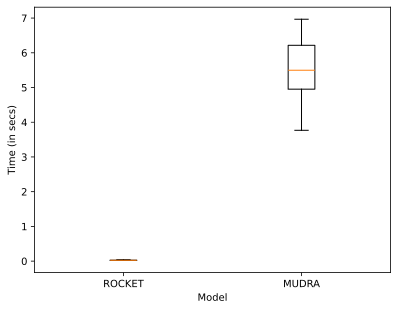

In [17]:
plt.xlabel('Model')
plt.ylabel('Time (in secs)')
plt.boxplot(times)
plt.xticks(np.arange(1, 3), ['ROCKET', 'MUDRA'])

# Results

## r=2

### Fitting the data

We run the model with the given input data

In [40]:
model = MUDRA(r=2, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

### Plot the estimated class functionals

We plot the estimated functionals. Each plot represents one feature, and each colour represents one class.

Let $S$ be the spline basis matrix evaluated at all time points for which any data was recorded. Then the class functionals can simply be estimated as $$Y=S(\lambda_0 + \Lambda\alpha_i\xi)$$, where each column represents one feature functional.

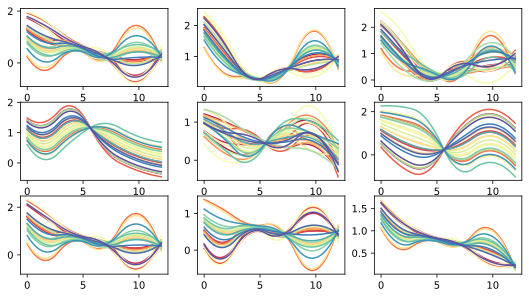

In [41]:
xs = np.linspace(0, 12, 100)
# S = model.basis(xs).squeeze().T
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
#     ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    ys = model.getClassFunctionals(xs, i+1)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Dimension Reduction

Let $Y$ be a new datapoint that is not in the training set. Similar to training, we will construct the corresponding $S_Y$ and $C_Y$ matrix. Define $M_Y = \sigma^2I + (C^T\Psi C)\otimes (S\Sigma S^T)$ and $A_Y=(\xi C)^T\otimes(S\Lambda)$. Then, we choose $\hat{\alpha}_Y$ such that $$vec(\hat{\alpha}_Y)=(A_Y^TM_Y^{-1}A_Y)^{-\frac{1}{2}}A_Y^TM_Y^{-1}Y$$ Reshaping into an $r\times r$ matrix and taking the diagonal elements, we arrive at an $r$ dimensional representation of $Y$ that has unit covariance, since $var(vec(Y))=A_Y^TM_Y^{-1}A_Y$.

### Classification

Classification of a sample is done by computing the posterior probabilities of belonging to each class, and then choosing the class with the highest posterior. $$P(\text{class}=i|Y) = \frac{P(Y|\text{class}=i)P(\text{class}=i)}{\sum_{k=1}^KP(Y|\text{class}=k)P(\text{class}=k)}$$ Simplifying this tells us that it is enough to find the class $i$ such that the value of $||\hat{\alpha}_Y - (A_Y^TM_Y^{-1})A)^{\frac{1}{2}}vec(\alpha_i)||_F$ is minimized.

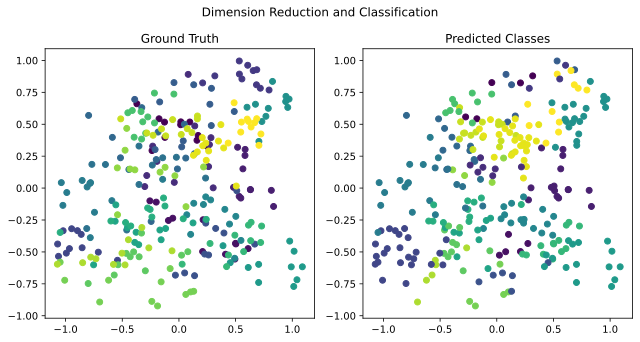

In [42]:
fig = plt.figure('Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121)
ax.scatter(pts[:,0], pts[:,3], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect(1)
ax = fig.add_subplot(122)
ax.scatter(pts[:,0], pts[:,3], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect(1)
fig.suptitle('Dimension Reduction and Classification')
fig.tight_layout()

In [43]:
X_test, y_test = pickle.load(open("datasets/testWordRecognition.pickle", 'rb'))
X_test = convertToDataFrame(X_test)
predY = model.predict(X_test)

In [44]:
print(classification_report(y_test, predY))

              precision    recall  f1-score   support

           1       0.22      0.17      0.19        12
           2       0.07      0.08      0.08        12
           3       0.54      0.58      0.56        12
           4       0.25      0.25      0.25        12
           5       0.25      0.33      0.29        12
           6       0.45      0.75      0.56        12
           7       0.33      0.08      0.13        12
           8       0.09      0.08      0.09        12
           9       0.20      0.08      0.12        12
          10       0.40      0.17      0.24        12
          11       0.44      0.58      0.50        12
          12       0.30      0.25      0.27        12
          13       0.46      0.50      0.48        12
          14       0.39      1.00      0.56        12
          15       0.12      0.08      0.10        12
          16       0.56      0.42      0.48        12
          17       0.43      0.25      0.32        12
          18       0.28    

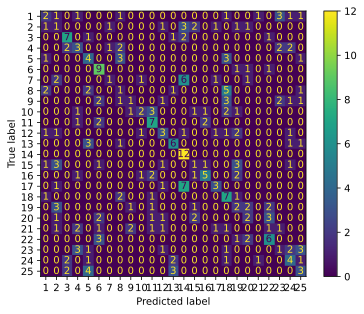

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, predY)

## r=3

### Fitting the data

In [46]:
model = MUDRA(r=3, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

### Plot the estimated class functionals

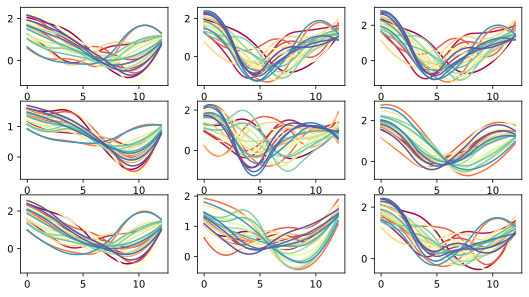

In [47]:
xs = np.linspace(0, 12, 100)
# S = model.basis(xs).squeeze().T
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
#     ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    ys = model.getClassFunctionals(xs, i+1)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Cluster plots

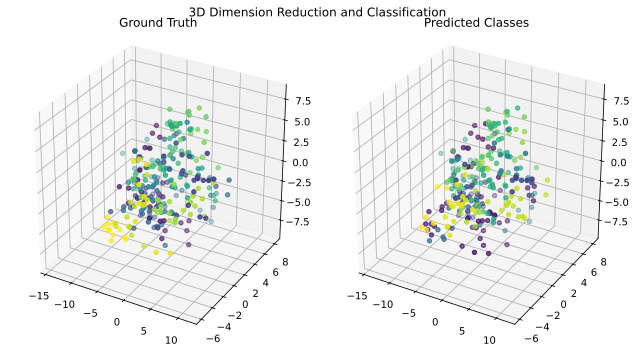

In [48]:
fig = plt.figure('3D Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts[:,0], pts[:,4], pts[:,8], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect((1, 1, 1))
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pts[:,0], pts[:,4], pts[:,8], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect((1, 1, 1))
fig.suptitle('3D Dimension Reduction and Classification')
fig.tight_layout()

### Classification Report

In [49]:
X_test, y_test = pickle.load(open("datasets/testWordRecognition.pickle", 'rb'))
X_test = convertToDataFrame(X_test)
predY = model.predict(X_test)
print(classification_report(y_test, predY))

              precision    recall  f1-score   support

           1       0.50      0.67      0.57        12
           2       0.33      0.25      0.29        12
           3       0.17      0.17      0.17        12
           4       0.25      0.42      0.31        12
           5       0.61      0.92      0.73        12
           6       0.56      0.75      0.64        12
           7       0.09      0.08      0.09        12
           8       0.40      0.17      0.24        12
           9       0.29      0.33      0.31        12
          10       0.75      1.00      0.86        12
          11       0.27      0.25      0.26        12
          12       0.18      0.17      0.17        12
          13       0.43      0.25      0.32        12
          14       0.33      0.33      0.33        12
          15       0.21      0.33      0.26        12
          16       0.27      0.25      0.26        12
          17       0.00      0.00      0.00        12
          18       0.08    

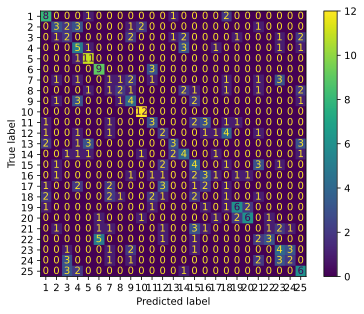

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, predY)